In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Load and Clean Data

In [7]:
# Load Dataset

file_path = "/Users/Sebastiano/data/Clinical_MRI.xlsx"
db = pd.read_excel(file_path)

print("N° of patients: {}".format(len(db)))
print("N° of columns: {}".format(db.shape[1]))
db.head()

N° of patients: 27
N° of columns: 969


,Patient,Date of Birth,Gender,Education,Disease duration (months),Age,SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),...,FO left thickness mm,FO left thickness norm.,FO thickness asymmetry,PO total thickness mm,PO total thickness norm.,PO right thickness mm,PO right thickness norm.,PO left thickness mm,PO left thickness norm.,PO thickness asymmetry
0,Paziente 1,30084,0,High School,109.5,38.00,0,0.0,1,1,...,2.2623,0.021072,18.2292,2.4475,0.022797,2.2930,0.021358,2.5970,0.024190,-12.4336
1,Paziente 2,26505,0,University,96.0,41.17,13,2.1,0,1,...,1.8574,0.017152,-18.2462,1.3628,0.012585,1.2929,0.011940,1.4317,0.013222,-10.1909
2,Paziente 3,31954,0,University,76.5,32.00,2,0.5,0,1,...,2.6216,0.024634,6.8561,2.3106,0.021711,2.4840,0.023341,2.1159,0.019882,16.0040
3,Paziente 4,32438,0,University,79.1,31.00,2,0.0,1,1,...,3.0341,0.028616,-6.5858,2.1641,0.020410,2.2997,0.021689,2.0193,0.019045,12.9849
4,Paziente 5,28445,0,high school,42.0,43.00,2,0.4,0,1,...,3.9152,0.035652,-10.4521,2.5960,0.023640,2.5593,0.023305,2.6209,0.023866,-2.3788


In [8]:
# Drop unwanted columns

df = db.drop(['Patient','Date of Birth', 'Gender', 'Education', 'Age'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 963 


In [9]:
## transform columns with high skewness.
#skewness = df.skew()
# Identify columns with high skewness
#high_skew_cols = skewness[abs(skewness) > 1].index.tolist()
#print('-------------------')
#print('High skewness columns:')
#print(high_skew_cols)

# Apply log transformation to high skewness columns
#for col in high_skew_cols:
 #   df[col] = np.log1p(df[col])

#df = df.fillna(df.median())

In [10]:
# One Hot Encoding for Scores, Antiplatelets and Coagulants, Therapy, NP Event

from sklearn.preprocessing import OneHotEncoder

categ = ['Antiplatelet', 'Anticoagulant', 'Antimalarial', 'Immunosuppressant', 'Biologic']
ohe = OneHotEncoder(categories='auto',sparse=False)
df_enc = ohe.fit_transform(df[categ])
df_enc = pd.DataFrame(df_enc,columns=ohe.get_feature_names_out(categ))
df = pd.concat([df, df_enc], axis=1)
df = df.drop(categ, axis=1)
df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Disease duration (months),SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),anti-dsDNA Titre (insert NV here <7 ),Anti-Ro-SSA,Anti-La-SSB,Anti-RNP,anti-Sm,...,Immunosuppressant_Azathioprine,Immunosuppressant_Cyclophosphamide,Immunosuppressant_Methotrexate,Immunosuppressant_Mycophenolate,Immunosuppressant_None,Immunosuppressant_azathioprine,Biologic_Belimumab,Biologic_None,Biologic_Rituximab,Biologic_tocilizumab
0,109.5,0,0.0,1,1,3.0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,96.0,13,2.1,0,1,84.4,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,76.5,2,0.5,0,1,4.0,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,79.1,2,0.0,1,1,5.0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,42.0,2,0.4,0,1,37.2,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Regression Analysis

In [11]:
# Define the target variable
target = 'NP-SLE'

# Define the predictor variables
predictors = ['SCA thickness asymmetry', 'Amygdala right volume %', 'Temporal thickness asymmetry', 'TMP thickness asymmetry', 'MTG thickness asymmetry', 'AnAb ', 'aPL syndrome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, random_state=42)

# Preprocess the data by standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a linear regression model
regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)

# Predict the target variable for the testing set
y_pred = regressor.predict(X_test)

# Evaluate the performance of the model using mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)


Mean Squared Error:  0.29831871364555906
R-squared:  -1.1478947382480253


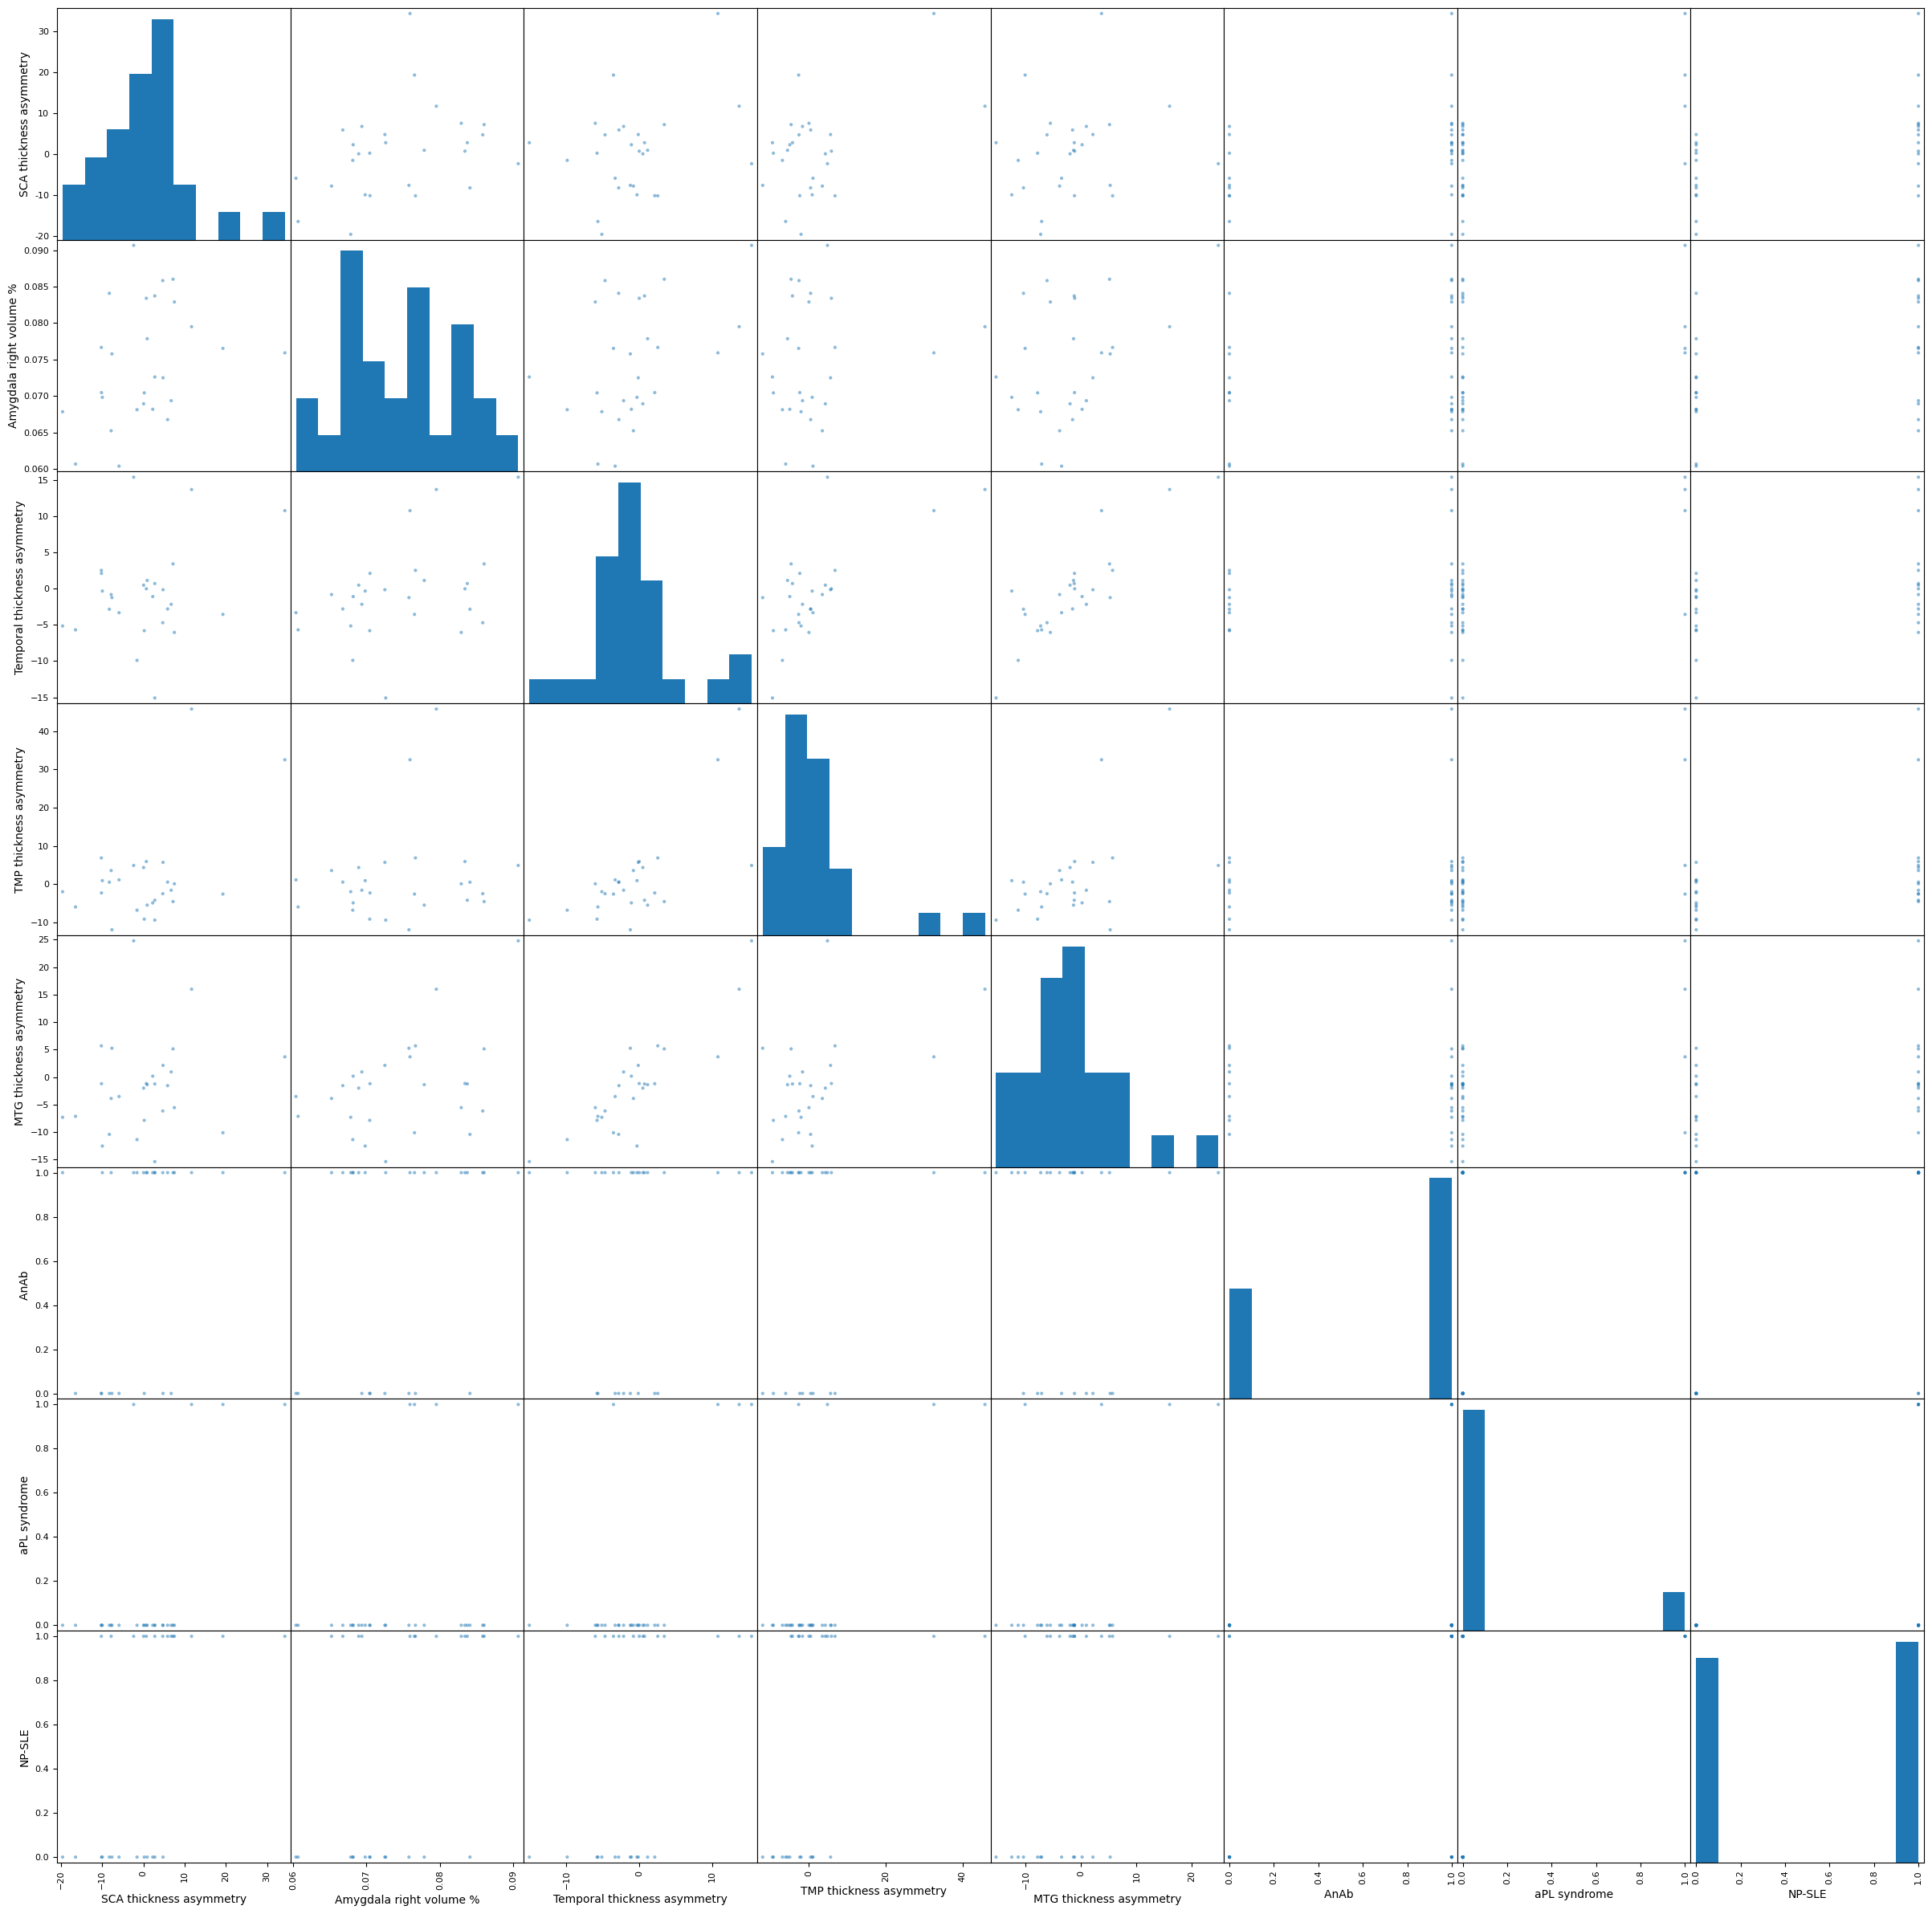

In [12]:
# Create a scatter plot matrix of the target variable against the predictor  variables
pd.plotting.scatter_matrix(df[predictors + [target]], figsize=(30, 30))
plt.show()


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

random_grid = [{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

# First create the base model to tune
lg = LogisticRegression(random_state=42)

# Random search of parameters, using 5 fold cross validation, different combinations, and use all available cores
lg_random = GridSearchCV(estimator = lg, param_grid=random_grid,
                               cv = 5)
# Fit the random search model
lg_random.fit(X_train, y_train)
lg_random.best_params_

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/en

{'C': 10, 'penalty': 'l2'}

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, classification_report

# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42, penalty='l2', C=10)
log_reg.fit(X_train, y_train)

# Evaluate the model on the testing data
score_log = log_reg.score(X_test, y_test)
print("### TESTING ###")
print("Logistic Regression's accuracy: ", round(score_log * 100, 2), "% \n")

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)
cm_log = confusion_matrix(y_test, y_pred)
print(cm_log, "\n")

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('1. The F-1 Score of the model: {} \n'.format(round(f1_score(y_test, y_pred, average='macro'), 2)))
print('2. The Recall Score of the model: {} \n'.format(round(recall_score(y_test, y_pred, average='macro'), 2)))
print('3. Classification report:\n{}'.format(classification_report(y_test, y_pred)))
print('4. AUC:\n{}\n'.format(roc_auc))

tn, fp, fn, tp = cm_log.ravel()

# Sensitivity, hit rate, Recall, or true positive rate
tpr = tp / (tp + fn)
print("Sensitivity (TPR): {}".format(tpr))

# Specificity or true negative rate
tnr = tn / (tn + fp)
print("Specificity (TNR): {}".format(tnr))

# Precision or positive predictive value
ppv = tp / (tp + fp)
print("Precision (PPV): {}".format(ppv))

# Negative predictive value
npv = tn / (tn + fn)
print("Negative Predictive Value (NPV): {}".format(npv))

# False positive rate
fpr = fp / (fp + tn)
print("False Positive Rate (FPR): {}".format(fpr))

### TESTING ###
Logistic Regression's accuracy:  66.67 % 

[[0 1]
 [1 4]] 

1. The F-1 Score of the model: 0.4 

2. The Recall Score of the model: 0.4 

3. Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5

    accuracy                           0.67         6
   macro avg       0.40      0.40      0.40         6
weighted avg       0.67      0.67      0.67         6

4. AUC:
0.4

Sensitivity (TPR): 0.8
Specificity (TNR): 0.0
Precision (PPV): 0.8
Negative Predictive Value (NPV): 0.0
False Positive Rate (FPR): 1.0
